# Duration Prediction Model

In [1]:
!python -V

Python 3.11.7


In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
import numpy as np

sns.set()

In [3]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc_taxi_experiment")

<Experiment: artifact_location='file:///c:/Users/mokon/Documents/Mlops-Zoomcamp/experiment_tracking/mlruns/1', creation_time=1747076093313, experiment_id='1', last_update_time=1747076093313, lifecycle_stage='active', name='nyc_taxi_experiment', tags={}>

In [4]:
df  = pd.read_parquet(r"C:\Users\mokon\Documents\Mlops-Zoomcamp\green_tripdata_2021-01.parquet")

In [5]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.50,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.50,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.50,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.50,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.00,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,2.75,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,0.00,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,2.75,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,2.75,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN


In [6]:
#Let's create our target which is the duration of the trip
df["duration"] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
df["duration"] = df["duration"].apply(lambda td: td.total_seconds()/60)
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,...,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


<Axes: xlabel='duration', ylabel='Density'>

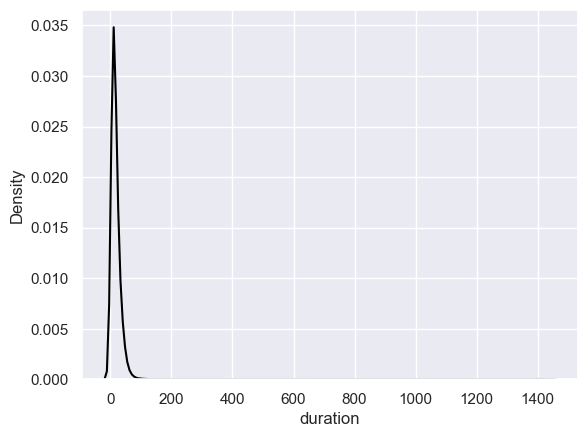

In [7]:
sns.kdeplot(df["duration"], color = "black")

In [8]:
#Let's filter those trips who lasted more than one minute and less than one hour
df = df[(df.duration >= 1) & (df.duration <= 60)]
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


In [9]:
#Let's filster the features we'll need
categorical = ["PULocationID","DOLocationID"]
numerical = ["trip_distance"]
df[categorical] = df[categorical].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73908 entries, 0 to 76517
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               73908 non-null  int64         
 1   lpep_pickup_datetime   73908 non-null  datetime64[us]
 2   lpep_dropoff_datetime  73908 non-null  datetime64[us]
 3   store_and_fwd_flag     38175 non-null  object        
 4   RatecodeID             38175 non-null  float64       
 5   PULocationID           73908 non-null  object        
 6   DOLocationID           73908 non-null  object        
 7   passenger_count        38175 non-null  float64       
 8   trip_distance          73908 non-null  float64       
 9   fare_amount            73908 non-null  float64       
 10  extra                  73908 non-null  float64       
 11  mta_tax                73908 non-null  float64       
 12  tip_amount             73908 non-null  float64       
 13  tolls_

C:\Users\mokon\AppData\Local\Temp\ipykernel_17752\1141934798.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [10]:
#We create the dictionaries to be able to one hot encode our features
train_dicts = df[categorical + numerical].to_dict(orient="records")
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
target ="duration"
y_train = df[target].values

#Let's create the model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred))

9.827368941909368

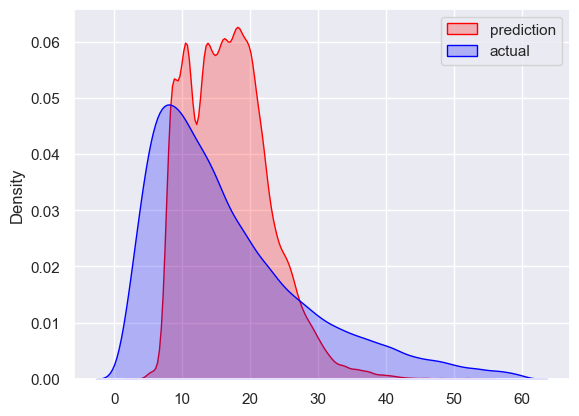

In [11]:
#Let's check some distribution
sns.kdeplot(y_pred, label="prediction",color="red", fill = True)
sns.kdeplot(y_train, label="actual", color="blue", fill = True)
plt.legend()

### Now let's try to use some test data

In [12]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [13]:
df_train = read_dataframe(r"C:\Users\mokon\Documents\Mlops-Zoomcamp\green_tripdata_2021-01.parquet")
df_test = read_dataframe(r"C:\Users\mokon\Documents\Mlops-Zoomcamp\green_tripdata_2021-02.parquet")

In [14]:
len(df_train), len(df_test)

(73908, 61921)

In [15]:
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_test["PU_DO"] = df_test["PULocationID"] + "_" + df_test["DOLocationID"]


In [16]:
categorical = ["PU_DO"]
numercial = ["trip_distance"]
dv = DictVectorizer()
train_dicts = df_train[categorical + numerical].to_dict(orient="records")
test_dicts = df_test[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)
X_test = dv.transform(test_dicts)


In [17]:
target = "duration"
y_train = df_train[target].values
y_test = df_test[target].values

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
np.sqrt(mean_squared_error(y_test,y_pred))

7.758715207172595

In [19]:
with open("models/lin_reg.bin","wb") as f_out:
    pickle.dump((dv,lr), f_out)

In [20]:
with mlflow.start_run():
    mlflow.set_tag("Developer","Abraham Alvarado")
    mlflow.log_param("Data_Path_training",r"C:\Users\mokon\Documents\Mlops-Zoomcamp\green_tripdata_2021-01.parquet")
    mlflow.log_param("Data_Path_validation",r"C:\Users\mokon\Documents\Mlops-Zoomcamp\green_tripdata_2021-02.parquet")
    alpha = 0.01
    mlflow.log_param("alpha",alpha)
    lr = Lasso(alpha)
    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    rmse = mean_squared_error(y_test,y_pred, squared=False)
    mlflow.log_metric("rmse",rmse)  
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="Models/pickle")  

In [21]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [22]:
train = xgb.DMatrix(X_train, label = y_train)
valid = xgb.DMatrix(X_test, label = y_test)

In [23]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model","XGBoost")
        mlflow.log_params(params)
        booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(valid, "validation")],
            early_stopping_rounds = 50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_test, y_pred, squared = False)
        mlflow.log_metric("rmse",rmse)
    return {"loss":rmse, "status": STATUS_OK}

In [24]:
search_space = {
    "max_depth": scope.int(hp.quniform("max_depth",4,100,1)),
    "learning_rate": hp.loguniform("learning_rate",-3,0), #Values form exp(-3) to exp(0)
    "reg_alpha": hp.loguniform("reg_alpha",-5,-1),
    "reg_lambda": hp.loguniform("reg_lambda",-6,-1),
    "min_child_weight": hp.loguniform("min_child_weight",-1,3),
    "objective": "reg:linear",
    "seed" : 42
}

best_result = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals=10,
    trials = Trials()
)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

c:\Users\mokon\Documents\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:12:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.62695                          
[1]	validation-rmse:9.46820                           
[2]	validation-rmse:8.63682                           
[3]	validation-rmse:8.05080                           
[4]	validation-rmse:7.64399                           
[5]	validation-rmse:7.36080                           
[6]	validation-rmse:7.16506                           
[7]	validation-rmse:7.03081                           
[8]	validation-rmse:6.93789                           
[9]	validation-rmse:6.86828                           
[10]	validation-rmse:6.81794                          
[11]	validation-rmse:6.78054                          
[12]	validation-rmse:6.75371                          
[13]	validation-rmse:6.73357                          
[14]	validation-rmse:6.71819                          
[15]	validation-rmse:6.70625                          
[16]	validation-rmse:6.69310                          
[17]	validation-rmse:6.68500                          
[18]	valid

c:\Users\mokon\Documents\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:17:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.92690                                                     
[1]	validation-rmse:6.61515                                                     
[2]	validation-rmse:6.57168                                                     
[3]	validation-rmse:6.55810                                                     
[4]	validation-rmse:6.54489                                                     
[5]	validation-rmse:6.53200                                                     
[6]	validation-rmse:6.52316                                                     
[7]	validation-rmse:6.51830                                                     
[8]	validation-rmse:6.50742                                                     
[9]	validation-rmse:6.50179                                                     
[10]	validation-rmse:6.49742                                                    
[11]	validation-rmse:6.49437                                                    
[12]	validation-rmse:6.49225

c:\Users\mokon\Documents\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:19:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.32569                                                     
[1]	validation-rmse:9.05052                                                      
[2]	validation-rmse:8.21283                                                      
[3]	validation-rmse:7.67013                                                      
[4]	validation-rmse:7.32537                                                      
[5]	validation-rmse:7.10527                                                      
[6]	validation-rmse:6.96554                                                      
[7]	validation-rmse:6.87333                                                      
[8]	validation-rmse:6.81355                                                      
[9]	validation-rmse:6.77238                                                      
[10]	validation-rmse:6.74285                                                     
[11]	validation-rmse:6.72234                                                     
[12]	validation-

c:\Users\mokon\Documents\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.96338                                                    
[1]	validation-rmse:9.97111                                                     
[2]	validation-rmse:9.18960                                                     
[3]	validation-rmse:8.58794                                                     
[4]	validation-rmse:8.12538                                                     
[5]	validation-rmse:7.77003                                                     
[6]	validation-rmse:7.49948                                                     
[7]	validation-rmse:7.28716                                                     
[8]	validation-rmse:7.12924                                                     
[9]	validation-rmse:7.00795                                                     
[10]	validation-rmse:6.91575                                                    
[11]	validation-rmse:6.84674                                                    
[12]	validation-rmse:6.79078

c:\Users\mokon\Documents\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.46429                                                    
[1]	validation-rmse:10.80507                                                    
[2]	validation-rmse:10.22640                                                    
[3]	validation-rmse:9.72083                                                     
[4]	validation-rmse:9.28046                                                     
[5]	validation-rmse:8.89767                                                     
[6]	validation-rmse:8.56634                                                     
[7]	validation-rmse:8.28047                                                     
[8]	validation-rmse:8.03387                                                     
[9]	validation-rmse:7.82158                                                     
[10]	validation-rmse:7.63928                                                    
[11]	validation-rmse:7.48368                                                    
[12]	validation-rmse:7.35020

c:\Users\mokon\Documents\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:29:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.88090                                                    
[1]	validation-rmse:9.84649                                                     
[2]	validation-rmse:9.05878                                                     
[3]	validation-rmse:8.46167                                                     
[4]	validation-rmse:8.01495                                                     
[5]	validation-rmse:7.68285                                                     
[6]	validation-rmse:7.43908                                                     
[7]	validation-rmse:7.25733                                                     
[8]	validation-rmse:7.12422                                                     
[9]	validation-rmse:7.02490                                                     
[10]	validation-rmse:6.95020                                                    
[11]	validation-rmse:6.89355                                                    
[12]	validation-rmse:6.85181

c:\Users\mokon\Documents\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:31:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.67218                                                     
[1]	validation-rmse:7.31020                                                     
[2]	validation-rmse:6.82035                                                     
[3]	validation-rmse:6.63604                                                     
[4]	validation-rmse:6.56068                                                     
[5]	validation-rmse:6.52191                                                     
[6]	validation-rmse:6.50284                                                     
[7]	validation-rmse:6.48598                                                     
[8]	validation-rmse:6.47542                                                     
[9]	validation-rmse:6.46848                                                     
[10]	validation-rmse:6.46324                                                    
[11]	validation-rmse:6.46012                                                    
[12]	validation-rmse:6.45622

c:\Users\mokon\Documents\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.21664                                                     
[1]	validation-rmse:6.76225                                                     
[2]	validation-rmse:6.68290                                                     
[3]	validation-rmse:6.65144                                                     
[4]	validation-rmse:6.64053                                                     
[5]	validation-rmse:6.62968                                                     
[6]	validation-rmse:6.62509                                                     
[7]	validation-rmse:6.61868                                                     
[8]	validation-rmse:6.61591                                                     
[9]	validation-rmse:6.61624                                                     
[10]	validation-rmse:6.61404                                                    
[11]	validation-rmse:6.61114                                                    
[12]	validation-rmse:6.60870

c:\Users\mokon\Documents\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:34:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.28008                                                     
[1]	validation-rmse:6.69734                                                     
[2]	validation-rmse:6.60551                                                     
[3]	validation-rmse:6.58171                                                     
[4]	validation-rmse:6.56601                                                     
[5]	validation-rmse:6.55935                                                     
[6]	validation-rmse:6.54954                                                     
[7]	validation-rmse:6.54303                                                     
[8]	validation-rmse:6.53991                                                     
[9]	validation-rmse:6.53722                                                     
[10]	validation-rmse:6.53095                                                    
[11]	validation-rmse:6.52405                                                    
[12]	validation-rmse:6.51977

c:\Users\mokon\Documents\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:35:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.86825                                                    
[1]	validation-rmse:9.82672                                                     
[2]	validation-rmse:9.03069                                                     
[3]	validation-rmse:8.43014                                                     
[4]	validation-rmse:7.98216                                                     
[5]	validation-rmse:7.65055                                                     
[6]	validation-rmse:7.40506                                                     
[7]	validation-rmse:7.22460                                                     
[8]	validation-rmse:7.09253                                                     
[9]	validation-rmse:6.99457                                                     
[10]	validation-rmse:6.92060                                                    
[11]	validation-rmse:6.86605                                                    
[12]	validation-rmse:6.82511

### Traiining the model with the best parameters

In [25]:

mlflow.xgboost.autolog(disable=True)

In [26]:
import mlflow.xgboost


with mlflow.start_run():
    best_params = {
        "max_depth": 49,
        "learning_rate": 0.07751107990817416,
        "reg_alpha": 0.01091034951195393,
        "reg_lambda": 0.004384675477877329,
        "min_child_weight": 2.7797098822431514,
        "objective": "reg:linear",
        "seed" : 42
    }

    mlflow.log_params(best_params)


    booster = xgb.train(
                params = best_params,
                dtrain = train,
                num_boost_round = 1000,
                evals = [(valid, "validation")],
                early_stopping_rounds = 50
            )
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    
    with open("Models/preprocessor.b","wb") as f_out:
        pickle.dump(dv, f_out)
    
    mlflow.log_metric("rmse",rmse)
    mlflow.log_artifact("Models/preprocessor.b", artifact_path="preprocessor")
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

c:\Users\mokon\Documents\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:38:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.58244
[1]	validation-rmse:11.01470
[2]	validation-rmse:10.50559
[3]	validation-rmse:10.04910
[4]	validation-rmse:9.64137
[5]	validation-rmse:9.27640
[6]	validation-rmse:8.95329
[7]	validation-rmse:8.66553
[8]	validation-rmse:8.41037
[9]	validation-rmse:8.18555
[10]	validation-rmse:7.98590
[11]	validation-rmse:7.81011
[12]	validation-rmse:7.65588
[13]	validation-rmse:7.52065
[14]	validation-rmse:7.40092
[15]	validation-rmse:7.29696
[16]	validation-rmse:7.20428
[17]	validation-rmse:7.12369
[18]	validation-rmse:7.05207
[19]	validation-rmse:6.99027
[20]	validation-rmse:6.93413
[21]	validation-rmse:6.88593
[22]	validation-rmse:6.84212
[23]	validation-rmse:6.80374
[24]	validation-rmse:6.76999
[25]	validation-rmse:6.73967
[26]	validation-rmse:6.71304
[27]	validation-rmse:6.68942
[28]	validation-rmse:6.66822
[29]	validation-rmse:6.64946
[30]	validation-rmse:6.63287
[31]	validation-rmse:6.61776
[32]	validation-rmse:6.60473
[33]	validation-rmse:6.59187
[34]	validation-rmse

c:\Users\mokon\Documents\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/13 21:48:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
